# NammaMetro Ridership Data Analysis

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

filename = "NammaMetro_Ridership_Dataset.csv"
df = pd.read_csv(filename, index_col=0)

## One Day on NammaMetro

#### Let's take a look at the daily ridership data that NammaMetro publishes

Source: [https://english.bmrc.co.in/ridership/](https://english.bmrc.co.in/ridership/)

The Namma Metro Ridership stats page publishes a breakdown of payment methods used daily by passengers entering the system.

![ridership_plot](nammametro_datapage.png)

### Earliest Record

In [60]:
df.head(1)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
0,26-10-2024,353460,352496,853,43,68,241883,7444,512,177279,49351,95571,32357


### Most Recent Record

In [61]:
df.tail(1)

,Record Date,Total Smart Cards,Stored Value Card,One Day Pass,Three Day Pass,Five Day Pass,Tokens,Total NCMC,Group Ticket,Total QR,QR NammaMetro,QR WhatsApp,QR Paytm
65,14-01-2025,138529,137591,818,54,66,191747,4573,306,149138,40216,81935,26987


#### Extend the table with two useful columns: `Day of Week` and `Total Riders`

In [62]:
df['Total Riders'] = df.loc[:, ['Total Smart Cards', 'Tokens', 'Total NCMC', 'Group Ticket', 'Total QR']].sum(axis=1).astype('Int64')
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%d-%m-%Y')
df['Day of Week'] = df['Record Date'].dt.day_name()

df[['Record Date', 'Day of Week', 'Total Riders']].tail(7)

,Record Date,Day of Week,Total Riders
59,2025-01-03,Friday,784453
60,2025-01-04,Saturday,770332
61,2025-01-05,Sunday,629755
62,2025-01-06,Monday,861593
63,2025-01-07,Tuesday,874099
64,2025-01-08,Wednesday,878637
65,2025-01-14,Tuesday,484293


### Passenger Flow: First Glance

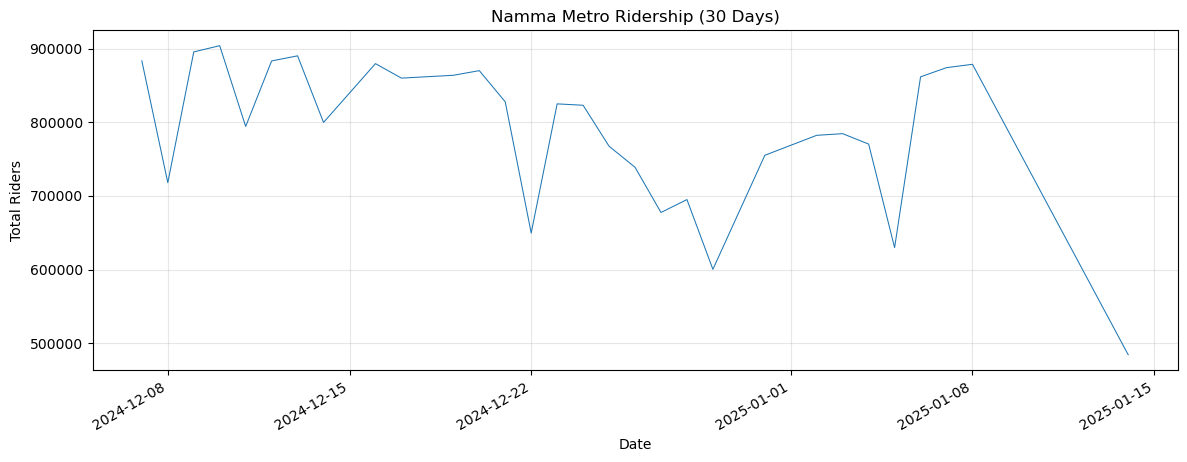

In [63]:
df.tail(30).plot(figsize=(14,5), 
                    kind='line', 
                    x='Record Date', 
                    xlabel='Date', 
                    y='Total Riders', 
                    ylabel='Total Riders', 
                    title='Namma Metro Ridership (30 Days)', 
                    legend=False,
                    linestyle='-',
                    linewidth=0.75)
plt.grid(True, alpha=0.3)
plt.show()

### Let's make a cleaner graph for the last N days of available data.

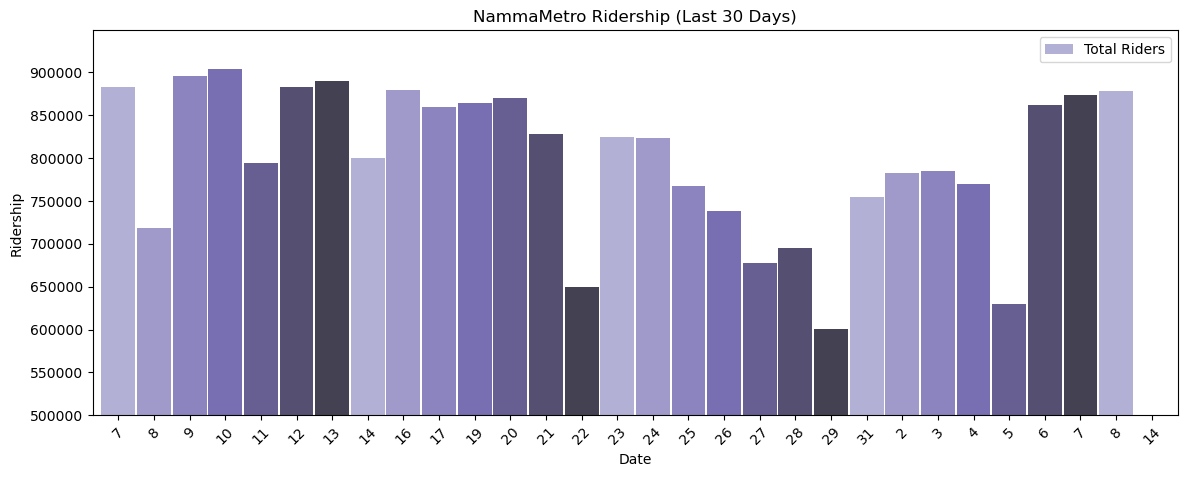

In [64]:
number_of_days = 30
Last_N_Days = df[['Record Date', 'Total Riders']].tail(number_of_days)
Last_N_Days['Record Date'] = pd.to_datetime(Last_N_Days['Record Date'], format='%d-%m-%Y').dt.day
Last_N_Days.plot(x='Record Date', 
                 y='Total Riders', 
                 kind='bar', 
                 xlabel='Date', 
                 ylabel='Ridership', 
                 title='NammaMetro Ridership (Last 30 Days)', 
                 figsize=(14,5), 
                 width=0.95,
                 legend=True,
                 color=sns.color_palette('Purples_d', 7),
                 rot=45)
plt.ylim(bottom=500000)
plt.show()

### Note the gaps in the data. 

NammaMetro fails to report ridership numbers on some days. Is someone updating the page manually?! 

Let's get a better understanding of that missing data.

In [65]:
from datetime import date, timedelta

start_date = date.today() - timedelta(number_of_days, 0, 0)
dates = pd.DataFrame({'Record Date': [str(start_date+timedelta(n)) for n in range(number_of_days)]})
dates['Record Date'] = pd.to_datetime(dates['Record Date'], format='%Y-%m-%d')
dates['Day of Week'] = dates['Record Date'].dt.day_name()

print(f"We will examine the data during the period of the last {number_of_days} calendar days, \
i.e. from {dates['Record Date'].min().strftime('%d-%m-%Y')} to {dates['Record Date'].max().strftime('%d-%m-%Y')}.")

We will examine the data during the period of the last 30 calendar days, i.e. from 16-12-2024 to 14-01-2025.


### Days of Missing Data

In [66]:
Last_N_Days = df.merge(dates, how='right', on='Record Date')
Last_N_Days.drop(['Stored Value Card', 'One Day Pass', 'Three Day Pass', 'Five Day Pass', 'QR NammaMetro', 'QR WhatsApp', 'QR Paytm'], axis=1, inplace=True)
Last_N_Days.rename(columns={'Total Smart Cards':'Smart Cards', 'Total NCMC':'NCMC', 'Total QR':'QR'}, inplace=True)

formatted_dates = pd.to_datetime(Last_N_Days['Record Date'], format='%Y-%m-%d').dt.strftime('%d')
formatted_numbers = Last_N_Days.loc[:, 'Smart Cards':'Total Riders'].astype('Int64')

Last_N_Days = pd.concat([formatted_dates, formatted_numbers, dates['Day of Week']], axis=1)
Last_N_Days[Last_N_Days['Total Riders'].isna()]

,Record Date,Smart Cards,Tokens,NCMC,Group Ticket,QR,Total Riders,Day of Week
2,18,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Wednesday
14,30,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Monday
16,01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Wednesday
24,09,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Thursday
25,10,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Friday
26,11,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Saturday
27,12,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Sunday
28,13,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,Monday


In [67]:
# For use later when creating the stacked area chart
imputed_days = Last_N_Days['Record Date'][Last_N_Days['Total Riders'].isna()].tolist()

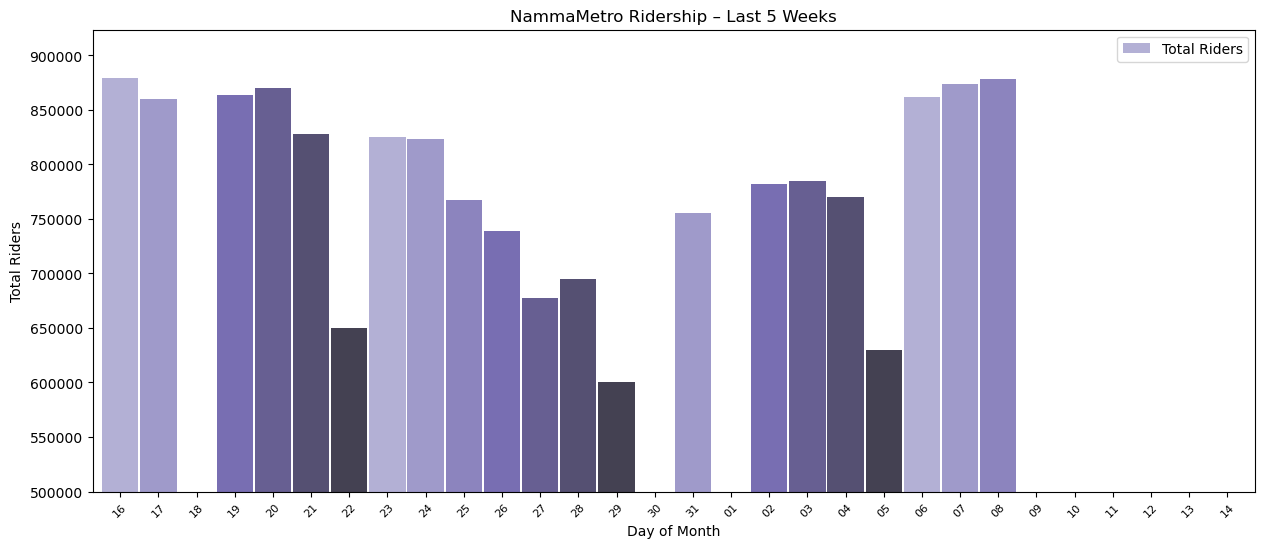

In [68]:
Last_N_Days.loc[:, :'Total Riders']\
           .plot(x='Record Date',
                 y='Total Riders',
                 kind='bar',
                 xlabel='Day of Month',
                 ylabel='Total Riders',
                 title='NammaMetro Ridership – Last 5 Weeks', 
                 figsize=(15,6),
                 width=0.95,
                 color=sns.color_palette('Purples_d', 7),
                 legend=True,
                 rot=45)
plt.ylim(bottom=500000)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.show()

### Looks like a mouth with a few broken teeth!

What sort of data imputation makes sense here? 

When the dataset grows large enough over several months, it makes sense to fill unreported dates with an average of similar days, e.g. If a weekday Tuesday was missing, take the average of the last 4 available weekday Tuesdays.

_____
## One Week on NammaMetro

### Smart Cards and Tokens are very popular with the public. Digital payments (QR and NCMC) are on the rise

In [69]:
df['Record Date'] = pd.to_datetime(df['Record Date'], format='%Y-%m-%d')
df['Day of Week'] = df['Record Date'].dt.day_name()
df['Day of Week'].value_counts()[['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']]

Day of Week
Sunday        9
Saturday     11
Friday        9
Thursday      8
Wednesday     8
Tuesday      12
Monday        9
Name: count, dtype: int64

In [70]:
weekly_average = df.merge(dates, how='right', on='Record Date')
weekly_average.drop(['Stored Value Card', 'One Day Pass', 'Three Day Pass', 'Five Day Pass', 'QR NammaMetro', 'QR WhatsApp', 'QR Paytm', 'Day of Week_x'], axis=1, inplace=True)
weekly_average.rename(columns={'Total Smart Cards':'Smart Cards', 'Total NCMC':'NCMC', 'Total QR':'QR', 'Day of Week_y':'Day of Week'}, inplace=True)

weekly_average = weekly_average.groupby('Day of Week')[['Smart Cards', 'Tokens', 'Group Ticket', 'QR', 'NCMC']].mean()
weekly_average = weekly_average.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

for col in ['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR']:
    weekly_average[col] = pd.to_numeric(weekly_average[col].fillna(0), errors='coerce').round().astype('Int64')

weekly_average['Total Riders'] = weekly_average.sum(axis=1)
weekly_average

,Smart Cards,Tokens,Group Ticket,QR,NCMC,Total Riders
Day of Week,,,,,,
Monday,442762,209208,404,190169,12818,855361
Tuesday,351713,230149,549,165863,11009,759283
Wednesday,350272,239944,692,221434,10691,823033
Thursday,406261,199989,419,176385,11891,794945
Friday,379311,201193,622,185121,11077,777324
Saturday,338666,199982,612,216597,8479,764336
Sunday,165248,251721,743,203968,4862,626542


### 👆🏼 NammaMetro is the officegoers commute of choice as seen by its popularity on weekdays.

From Monday to Friday, the daily ridership consistently exceeds 800,000. 

On the weekends, traffic eases but only slightly. Saturday is still a working day for many in this city. 

### 👆🏼 Surprising find — Smart Card usage peaks during the week, Token usage peaks on weekends.

This could suggest weekend demand is driven by non-regular users, e.g. road commuters who prefer using public transport on the weekends.

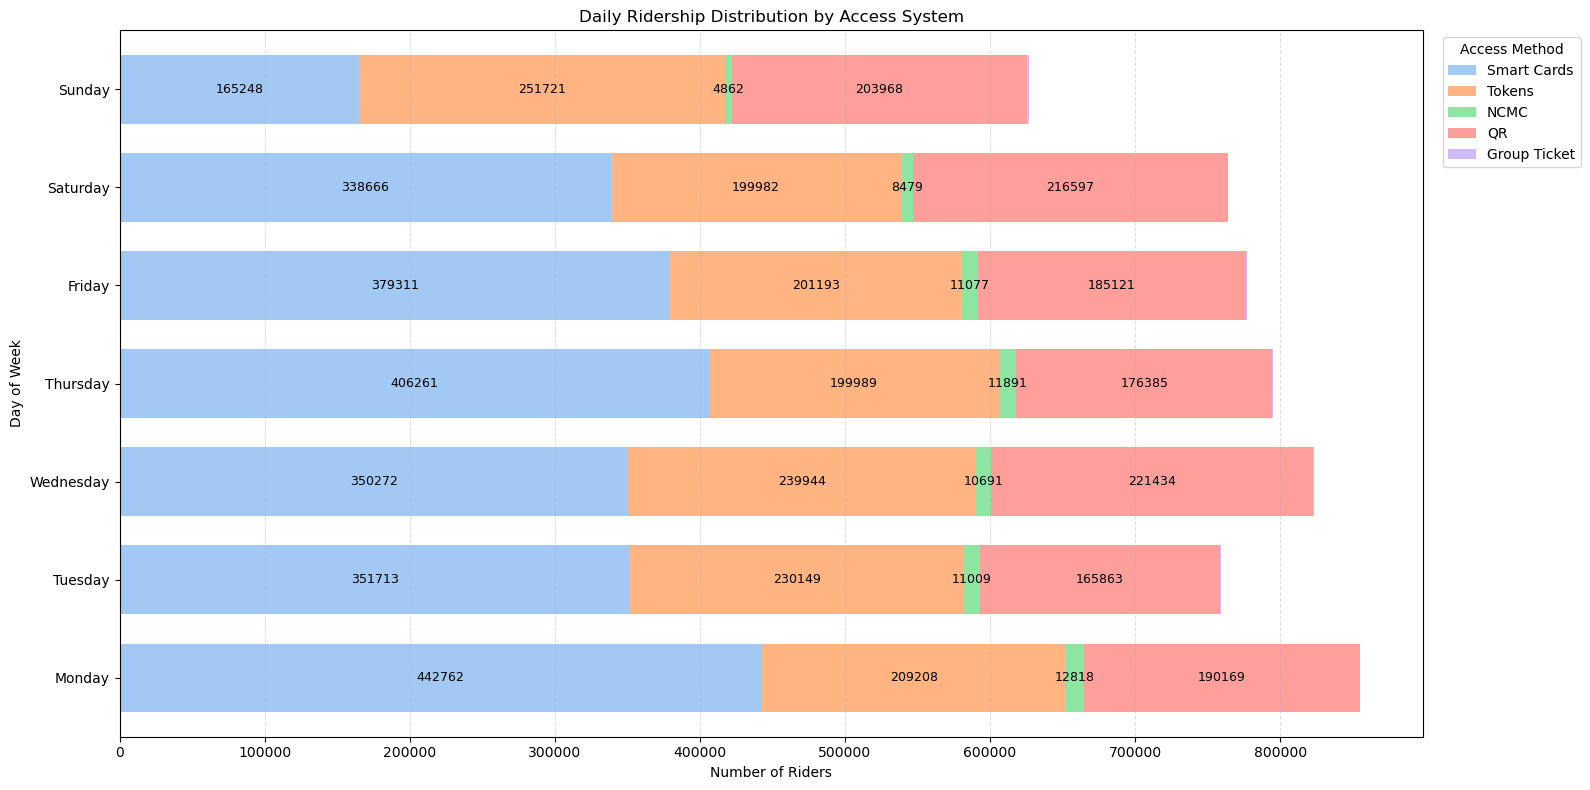

In [71]:
ax = weekly_average.loc[:, ['Smart Cards', 'Tokens', 'NCMC', 'QR', 'Group Ticket']].plot(kind='barh', 
                         stacked=True,
                         color=sns.color_palette('pastel', 5),
                         figsize=(16, 8),
                         width=0.7,
                         rot=0)

plt.title('Daily Ridership Distribution by Access System')
plt.ylabel('Day of Week')
plt.xlabel('Number of Riders')
plt.legend(title='Access Method', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.4)

for c in ax.containers:
    labels = ['%.0f' % v if v >= 4000 else '' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=9)

plt.tight_layout()
plt.show()

_____

![Crossed daily ridership of 700,000 in October 2023](nammametro_record1.png)

## The Metro is Getting Crowded

### Top 10 Busiest Days

In [72]:
busiest_days = df[['Record Date', 'Total Riders', 'Day of Week']].sort_values('Total Riders', ascending=False)
busiest_days.reset_index(drop=True, inplace=True)
busiest_days.index = range(1, len(busiest_days) + 1)
busiest_days.head(10)

,Record Date,Total Riders,Day of Week
1,2024-12-10,903928,Tuesday
2,2024-12-04,901475,Wednesday
3,2024-12-05,901230,Thursday
4,2024-12-09,895461,Monday
5,2024-12-13,890143,Friday
6,2024-11-19,889113,Tuesday
7,2024-12-07,883300,Saturday
8,2024-12-12,883218,Thursday
9,2024-12-16,879557,Monday
10,2025-01-08,878637,Wednesday


### 👆🏼 NammaMetro is the officegoers commute of choice as seen by its popularity on weekdays. 

### 👆🏼 In December 2024, NammaMetro daily ridership crossed 900,000 for the first time!

The daily ridership hit a record of 700,000 passengers in October 2023. It took just a little over a year to add 200,000 riders/day to the system.

### Least Busy Days so far

In [73]:
busiest_days.tail(10)

,Record Date,Total Riders,Day of Week
57,2024-11-10,654523,Sunday
58,2024-12-22,649582,Sunday
59,2024-10-27,637048,Sunday
60,2025-01-05,629755,Sunday
61,2024-12-29,600289,Sunday
62,2024-12-01,575702,Sunday
63,2024-11-03,536524,Sunday
64,2025-01-14,484293,Tuesday
65,2024-11-02,480284,Saturday
66,2024-11-01,404342,Friday


______

## One Month on NammaMetro

In [74]:
df[df['Record Date'] >= '2024-11-01'].groupby(df['Record Date'].dt.to_period('M'))['Total Riders'].sum().astype('Int64')

Record Date
2024-11    19717435
2024-12    22363482
2025-01     6065410
Freq: M, Name: Total Riders, dtype: Int64

Monthly ridership totals calulated from the data is bound to be inaccurate as NammaMetro fails to report ridership numbers on some days.

Official monthly ridership as reported on the NammaMetro website is as follows:

- 2024 September: 23,072,685
- 2024 November: 23,613,895
- 2024 December: 24,982,906

#### Prepare the data to plot a bar chart stacked by access method

#### Impute missing data with the average of similar days

In [75]:
Last_N_Days = Last_N_Days.set_index('Day of Week')
Last_N_Days.fillna(weekly_average, inplace=True)
Last_N_Days.reset_index(inplace=True)
Last_N_Days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Day of Week   30 non-null     object
 1   Record Date   30 non-null     object
 2   Smart Cards   30 non-null     Int64 
 3   Tokens        30 non-null     Int64 
 4   NCMC          30 non-null     Int64 
 5   Group Ticket  30 non-null     Int64 
 6   QR            30 non-null     Int64 
 7   Total Riders  30 non-null     Int64 
dtypes: Int64(6), object(2)
memory usage: 2.2+ KB


In [76]:
Last_N_Days_melt = Last_N_Days.melt(
                    id_vars=['Record Date'], 
                    value_vars=['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR'], 
                    var_name='Access Method', 
                    value_name='Count')
Last_N_Days_melt

,Record Date,Access Method,Count
0,16,Smart Cards,463552
1,17,Smart Cards,470382
2,18,Smart Cards,350272
3,19,Smart Cards,459928
4,20,Smart Cards,439068
...,...,...,...
145,10,QR,185121
146,11,QR,216597
147,12,QR,203968
148,13,QR,190169


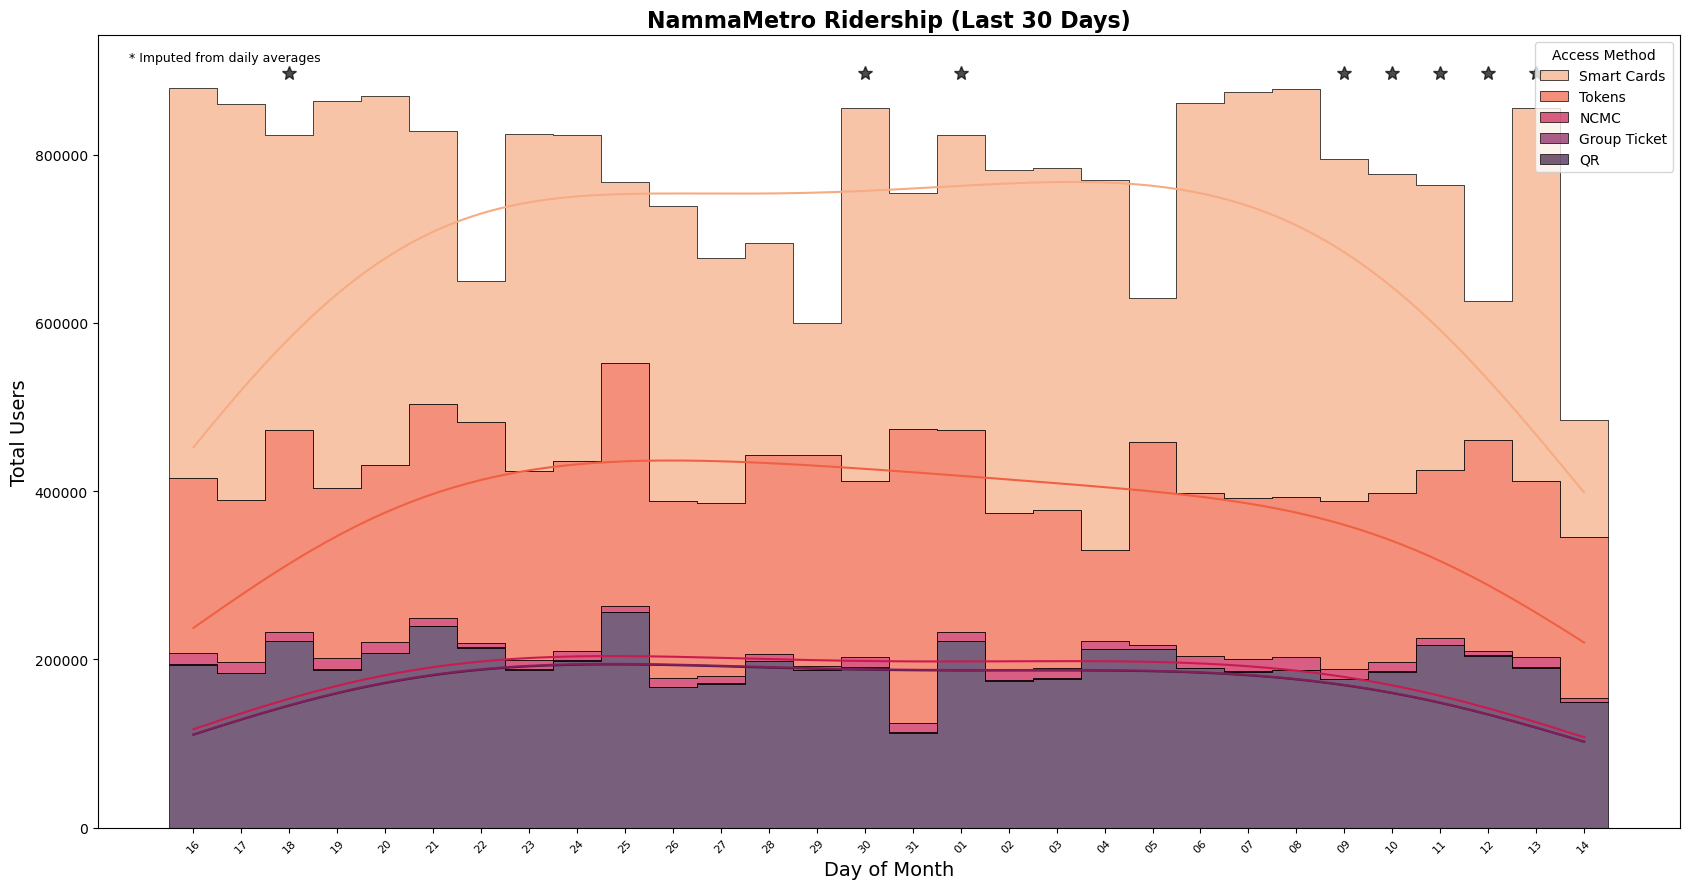

In [77]:
# Creating the stacked area plot
plt.figure(figsize=(17,9))
sns.histplot(data=Last_N_Days_melt, x='Record Date',
             weights='Count',       bins=number_of_days,
             hue='Access Method',   multiple='stack', 
             element='step',        palette='rocket_r',
             legend=True,           common_norm=True,
             stat='count',          linewidth=0.5,
             alpha=0.7,             discrete=True, 
             kde=True)
plt.xlabel('Day of Month', fontsize=14)
plt.ylabel('Total Users', fontsize=14)
plt.title(f'NammaMetro Ridership (Last {number_of_days} Days)', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)

# Get the y-coordinate for the markers (slightly above the highest point)
y_max = Last_N_Days[['Smart Cards', 'Tokens', 'NCMC', 'Group Ticket', 'QR']].sum(axis=1).max()
marker_y = y_max * 1.02  # Place markers 2% above the highest point

# Add markers for imputed data
for day in imputed_days:
    plt.plot(day, marker_y, 'k*', markersize=10, alpha=0.7)

# Add a note in the legend or as text
plt.text(0.02, 0.98, '* Imputed from daily averages', 
         transform=plt.gca().transAxes, 
         fontsize=9, 
         verticalalignment='top')

plt.tight_layout()
plt.show()